In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

In [41]:
# check GPU 
torch.cuda.is_available()

True

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# 訓練用 超參數
IMAGE_SIZE = 28
NUM__CLASSES = 10
EPOCHS = 20
BATCH_SIZE = 128

In [64]:
# 下載資料集
train_dataset = dsets.MNIST(root=r'./',
                            train=True,
                            # 載入時候 直接影響轉tensor
                            transform=transforms.ToTensor(),
                            download=True
                            )
                            
test_dataset = dsets.MNIST(root='r./',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=True
                           )

In [5]:
# DATALOADER(資料載入器) --> 自動一批一批輸出資料
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True
                                            )

In [6]:
indicies = range(len(test_dataset))
indicies_val = indicies[:5000]
indicies_test = indicies[5000:]

In [7]:
# SubsetRandomSampler 取樣器 --> 每批取資料集中樣本的方法
#                           ==> 完全隨機取出
sampler_val = torch.utils.data.SubsetRandomSampler(indicies_val)
sampler_test = torch.utils.data.SubsetRandomSampler(indicies_test)

In [62]:
# 將上面的取樣器定義 載入 載入器
val_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         sampler=sampler_val
                                         )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         sampler=sampler_test
                                         )

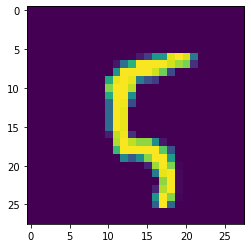

In [9]:
idx = 100
# 隨便取一張圖片 
# tensor 轉 numpy
mute_img = train_dataset[idx][0]
# 方法1 tensor.view 轉 大小
plt.imshow(mute_img.view(28,28))

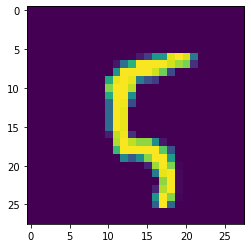

In [10]:
# 方法2 
plt.imshow(mute_img.numpy()[0,...])

**建立神經網路**

---



---



In [91]:
# 定義神經網路, 4, 8 為人為指定的兩個捲基層的厚度 (feature map 的數量)
DEPTH = [4, 8]
# 訓練用 超參數
IMAGE_SIZE = 28
NUM__CLASSES = 10
EPOCHS = 10
BATCH_SIZE = 128

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1 ,4 ,5 ,padding=2)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(DEPTH[0], DEPTH[1], 5, padding=2)
        self.fc1 = nn.Linear(IMAGE_SIZE//4 * IMAGE_SIZE//4 * DEPTH[1], 512)
        self.fc2 = nn.Linear(512, NUM__CLASSES)

    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, IMAGE_SIZE//4 * IMAGE_SIZE//4 * DEPTH[1])
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        
        return x 
    
    def retrieve_features(self, x):

        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)

        feature_map2 = F.relu(self.conv1(x))

        return (feature_map1, feature_map2)

def rightness(output, target):
    preds = output.data.max(dim=1, keepdim=True)[1]
    return preds.eq(target.data.view_as(preds)).cuda().sum(), len(target)

net = ConvNet().cuda()
net

ConvNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=392, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [92]:
# loss function and optimizer 
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
loss = nn.CrossEntropyLoss()

# records 
record = list() # a container of accuracies, losses
weights = list() # a container of weights

# start training
for epoch in range(EPOCHS):
    train_rights = list()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data = data.cuda()
        target = target.cuda()
        
        net.train()

        output = net(data.cuda())
        
        this_loss = loss(output, target)
        # 清空梯度
        optimizer.zero_grad()
        # 反向傳播
        this_loss.backward()
        # 一步隨機梯度下降 演算法
        optimizer.step()
        right = rightness(output, target)        

        train_rights.append(right)
        
        if batch_idx%100==0:
            net.eval()
            
            val_rights = list()

            for (data, target) in val_loader:
                data, target = Variable(data), Variable(target)
                data = data.cuda()
                target = target.cuda()
                output = net(data.cuda())

                right = rightness(output, target)
                #print(right[0].item())
                val_rights.append(right)
                
            train_r = (
                sum([tup[0].item() for tup in train_rights]), 
                sum([tup[1] for tup in train_rights])
            )
            
            

            val_r =(
                sum([tup[0] for tup in val_rights]), 
                sum([tup[1] for tup in val_rights])
            )
            
            #print(this_loss.data.item())
            acc = float(100. * train_r[0]/train_r[1])
            los_acc =float(100. * val_r[0]/val_r[1])
            print(f"epoch: {epoch+1} [{(batch_idx*len(data))}/{len(train_loader.dataset)}  ({(round(100.*batch_idx/len(train_loader), 2))}%)]\t Loss: {round(this_loss.item(), 5)}\tacc: {round(acc,5)}%\tloss_acc: {round(los_acc,5)}%")
            
            record.append((100 - 100. * train_r[0]/train_r[1], 100 - 100. * val_r[0]/val_r[1]))
            weights.append([net.conv1.weight.data.clone(), 
                            net.conv1.bias.data.clone(),
                            net.conv2.weight.data.clone(), 
                            net.conv2.bias.data.clone()                            
                            ])





epoch: 1 [0/60000  (0.0%)]	 Loss: 2.30119	acc: 7.8125%	loss_acc: 10.6%
epoch: 1 [800/60000  (21.32%)]	 Loss: 2.25798	acc: 14.38738%	loss_acc: 41.28%
epoch: 1 [1600/60000  (42.64%)]	 Loss: 0.37528	acc: 37.78762%	loss_acc: 86.8%
epoch: 1 [2400/60000  (63.97%)]	 Loss: 0.2191	acc: 54.91331%	loss_acc: 92.57999%
epoch: 1 [3200/60000  (85.29%)]	 Loss: 0.24889	acc: 64.45215%	loss_acc: 94.39999%
epoch: 2 [0/60000  (0.0%)]	 Loss: 0.06333	acc: 96.875%	loss_acc: 94.39999%
epoch: 2 [800/60000  (21.32%)]	 Loss: 0.10569	acc: 94.7401%	loss_acc: 95.16%
epoch: 2 [1600/60000  (42.64%)]	 Loss: 0.1613	acc: 95.11427%	loss_acc: 95.98%
epoch: 2 [2400/60000  (63.97%)]	 Loss: 0.21801	acc: 95.21647%	loss_acc: 96.5%
epoch: 2 [3200/60000  (85.29%)]	 Loss: 0.10119	acc: 95.48589%	loss_acc: 96.84%
epoch: 3 [0/60000  (0.0%)]	 Loss: 0.18573	acc: 92.96875%	loss_acc: 96.86%
epoch: 3 [800/60000  (21.32%)]	 Loss: 0.06212	acc: 96.20978%	loss_acc: 97.04%
epoch: 3 [1600/60000  (42.64%)]	 Loss: 0.07567	acc: 96.5796%	loss_acc: 

In [97]:
# 測試模型
net.eval() # 標誌著模型目前為執行時
vals = list() # 紀錄準確率所用清單

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    data = data.cuda()
    target = target.cuda()

    output = net(data)
    val = rightness(output, target)
    vals.append(val)

# 計算準確率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0] / rights[1]
print(right_rate.item(),'%')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


0.995199978351593 %


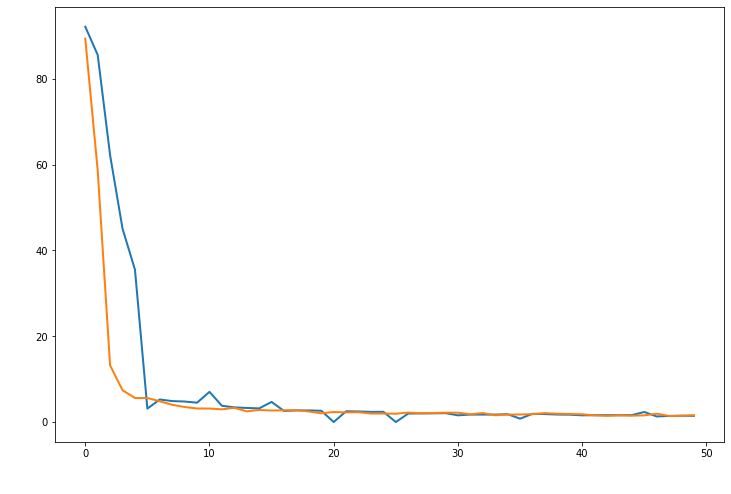

In [109]:
plt.figure(figsize=(12, 8))
plt.plot(record, linewidth=2)
plt.xlabel("Steps", color='w', size=24)
plt.ylabel("Error Rate",  color='w', size=24)
plt.show()
